,ray1,ray2,ray3,ray4,ray5,kartx,karty,kartz,time,action
0,-1.0,6.520963,4.611085,6.489805,4.588916,15.98892,0.264488,3.105164,0.100632,ACCELERATE
1,-1.0,6.520926,4.611081,6.489840,4.588920,15.98892,0.273206,3.105036,0.208055,ACCELERATE
2,-1.0,6.520916,4.611076,6.489851,4.588925,15.98892,0.275302,3.105015,0.311390,ACCELERATE
3,-1.0,6.520908,4.611072,6.489858,4.588930,15.98893,0.275676,3.105012,0.401621,ACCELERATE
4,-1.0,6.520902,4.611067,6.489865,4.588934,15.98893,0.275743,3.105016,0.500187,ACCELERATE
...,...,...,...,...,...,...,...,...,...,...
630,-1.0,9.962925,7.519180,2.335341,1.693479,13.09251,0.279252,-22.486220,33.601730,BRAKE
631,-1.0,-1.000000,7.471256,2.366221,1.741406,13.14054,0.279252,-21.574620,33.700840,BRAKE
632,-1.0,-1.000000,7.421791,2.406366,1.790877,13.18980,0.279252,-20.638040,33.802400,BRAKE
633,-1.0,-1.000000,7.373072,2.471813,1.839601,13.23851,0.279252,-19.711080,33.902700,BRAKE


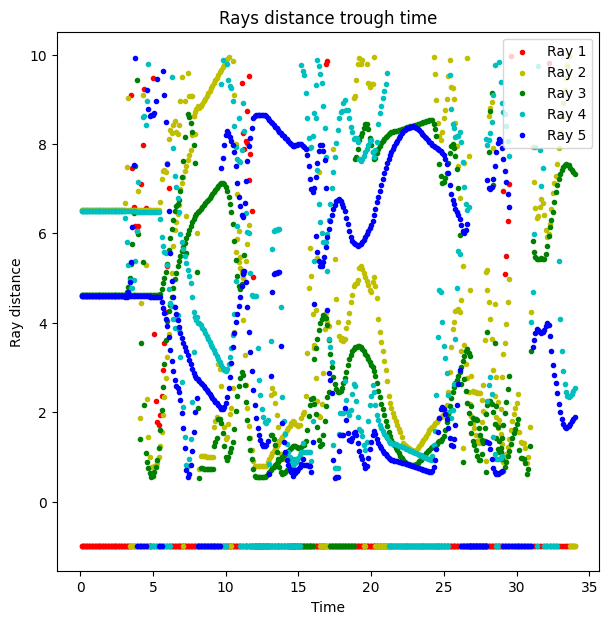

In [5]:
from ann import cost, cost_regL2, backprop, backprop2, predict, feedForward
from Utils import ExportONNX_JSON_TO_Custom, ExportAllformatsMLPSKlearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

#Colormaps https://matplotlib.org/stable/users/explain/colors/colormaps.html#references

#Nota: para calcular la precision del modelo vamos a redondear la salida, pues nos
#interesa saber que el modelo gira a la derecha, no que esta 95% seguro de girar a la derecha

#Ejercicio 2
kartData = pd.DataFrame()

trainFiles = 2
for i in range(trainFiles):
    newKartData = pd.read_csv(f'AAKart/ML/Kart{i:02d}.csv')
    
    kartData = pd.concat([kartData, newKartData], axis=0, ignore_index=True)

display(kartData)

#Tabla posicion 2D a traves del tiempo
positionThroughTime = px.scatter_3d(kartData, x='kartx', y='kartz', z='time', color='action', 
                                    color_discrete_sequence=px.colors.qualitative.Set1)
positionThroughTime.update_traces(marker_size = 3)

positionThroughTime.update_layout(scene=dict(xaxis_title='Kart X', yaxis_title='Kart Z', zaxis_title='Time'))
positionThroughTime.update_layout(legend_title='Action')
positionThroughTime.update_layout(title='Kart 2D position through time')

positionThroughTime.show()

#Distancia de los rayos a traves del tiempo
plt.figure(figsize=(7, 7))
plt.scatter(kartData['time'], kartData['ray1'], c='r', marker='.', label="Ray 1")
plt.scatter(kartData['time'], kartData['ray2'], c='y', marker='.', label="Ray 2")
plt.scatter(kartData['time'], kartData['ray3'], c='g', marker='.', label="Ray 3")
plt.scatter(kartData['time'], kartData['ray4'], c='c', marker='.', label="Ray 4")
plt.scatter(kartData['time'], kartData['ray5'], c='b', marker='.', label="Ray 5")
plt.xlabel('Time')
plt.ylabel('Ray distance')
plt.legend()
plt.title('Rays distance trough time')
plt.show()

,ray1,ray2,ray3,ray4,ray5,kartx,kartz,action
0,1.0,0.626964,0.458187,0.628336,0.431888,15.98892,3.105164,ACCELERATE
1,1.0,0.626960,0.458186,0.628340,0.431888,15.98892,3.105036,ACCELERATE
2,1.0,0.626959,0.458186,0.628341,0.431889,15.98892,3.105015,ACCELERATE
3,1.0,0.626958,0.458185,0.628342,0.431889,15.98893,3.105012,ACCELERATE
4,1.0,0.626958,0.458185,0.628343,0.431890,15.98893,3.105016,ACCELERATE
...,...,...,...,...,...,...,...,...
630,1.0,1.000000,0.784828,0.174049,0.123239,13.09251,-22.486220,BRAKE
631,1.0,1.000000,0.779445,0.177426,0.128348,13.14054,-21.574620,BRAKE
632,1.0,1.000000,0.773889,0.181816,0.133622,13.18980,-20.638040,BRAKE
633,1.0,1.000000,0.768417,0.188972,0.138815,13.23851,-19.711080,BRAKE


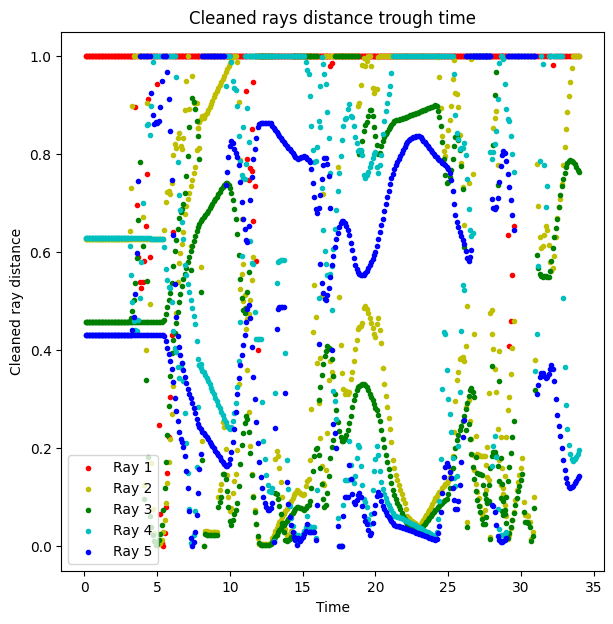

In [6]:
from sklearn.preprocessing import MinMaxScaler

#Ejercicio 3

#Kart y y time son inutiles para el modelo
cleanKartData = kartData.drop(columns=['karty', 'time'])

#Normalizar distancia de obstaculos en cada rayo
scaler = MinMaxScaler()

columnsToNormalize = ['ray1', 'ray2', 'ray3', 'ray4', 'ray5']

for column in columnsToNormalize:
    mask = (kartData[column] != -1)
    cleanKartData.loc[mask, column] = scaler.fit_transform(cleanKartData.loc[mask, [column]])
    
    #Si no hemos chocado con nada, significa que "no hay peligro", es decir, que tenemos la distancia del rayo segura
    invalidMask = (kartData[column] == -1)
    cleanKartData.loc[invalidMask, column] = 1

display(cleanKartData)

#Distancia limpia de los rayos a traves del tiempo
plt.figure(figsize=(7, 7))
plt.scatter(kartData['time'], cleanKartData['ray1'], c='r', marker='.', label="Ray 1")
plt.scatter(kartData['time'], cleanKartData['ray2'], c='y', marker='.', label="Ray 2")
plt.scatter(kartData['time'], cleanKartData['ray3'], c='g', marker='.', label="Ray 3")
plt.scatter(kartData['time'], cleanKartData['ray4'], c='c', marker='.', label="Ray 4")
plt.scatter(kartData['time'], cleanKartData['ray5'], c='b', marker='.', label="Ray 5")
plt.xlabel('Time')
plt.ylabel('Cleaned ray distance')
plt.legend()
plt.title('Cleaned rays distance trough time')
plt.show()

#Exportamos cleanKartData a Unity. Allí se programará el feedforward.

In [7]:
from sklearn.preprocessing import LabelEncoder

#Ejercicio 4

#El modelo predice la action mas probable que haría el jugador grabado en kartData
X = cleanKartData.drop(columns=['action'])
y = cleanKartData['action']

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)

print("X shape ", X.shape, "\ty shape ", y.shape, "\tY shape ", Y.shape)

#Número de neuronas de cada capa. Experimentar con el número de neuronas y de capas para conseguir un mejor resultado
#A mayor número de capas, mejor capacidad para aprender representaciones jerárquicas y características abstractas de los datos.
#A mayor número de neuronas, mejor capacidad para aprender representaciones más complejas de los datos.
#Sin embargo, al aumentar estos números, puede aumentar el riesgo de sobreajuste, 
#especialmente si no hay suficientes datos de entrenamiento.
layer_sizes = [X.shape[1], 10, len(kartData['action'].unique())]
epsilon = 0.12
theta_list = []

for i in range(len(layer_sizes) - 1):
    theta_list.append(np.random.rand(layer_sizes[i + 1], layer_sizes[i] + 1) * 2 * epsilon - epsilon)

iterations = 1000
lambda_ = 1
alpha = 1

for i in range(iterations):
    cost, grads = backprop(theta_list, X, Y, lambda_)
    
    print(f'Coste en la iteración {i + 1}: {cost}')

    for j in range(len(theta_list)):
        theta_list[j] -= alpha * grads[j]
        
testData = pd.DataFrame()

testFiles = 2
for i in range(trainFiles, trainFiles + testFiles):
    newTestData = pd.read_csv(f'AAKart/ML/Kart{i:02d}.csv')
    
    testData = pd.concat([testData, newTestData], axis=0, ignore_index=True)

display(testData)

cleanTestData = testData.drop(columns=['karty', 'time'])

for column in columnsToNormalize:
    mask = (kartData[column] != -1)
    cleanTestData.loc[mask, column] = scaler.fit_transform(cleanTestData.loc[mask, [column]])
    
    #Si no hemos chocado con nada, significa que "no hay peligro", es decir, que tenemos la distancia del rayo segura
    invalidMask = (kartData[column] == -1)
    cleanTestData.loc[invalidMask, column] = 1

display(cleanTestData)

X_test = cleanTestData.drop(columns=['action'])
y_test = cleanTestData['action']
Y_test = label_encoder.transform(y_test)

predictions = predict(theta_list, X_test)

accuracy = np.mean(predictions == Y_test)
print(f'Precisión en los datos de prueba: {accuracy}')

X shape  (635, 7) 	y shape  (635,) 	Y shape  (635,)


ValueError: operands could not be broadcast together with shapes (635,) (635,7) 